# Imports

In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from tp_models import init_denoising, pnp_pgd_denoising, red_denoising, crr_nn_denoising, psnr

import cv2

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [10]:
!wget https://perso.telecom-paristech.fr/aleclaire/mva/tp9.zip
!unzip tp9.zip
!rm -r im
!rm tp9.zip

--2025-03-21 19:57:25--  https://perso.telecom-paristech.fr/aleclaire/mva/tp9.zip
Résolution de perso.telecom-paristech.fr (perso.telecom-paristech.fr)… 2a04:8ec0:0:a::89c2:16e3, 137.194.22.227
Connexion à perso.telecom-paristech.fr (perso.telecom-paristech.fr)|2a04:8ec0:0:a::89c2:16e3|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 501814458 (479M) [application/zip]
Sauvegarde en : « tp9.zip »

tp9.zip             100%[===================>] 478,57M  38,1MB/s    ds 15s     

2025-03-21 19:57:40 (32,8 MB/s) — « tp9.zip » sauvegardé [501814458/501814458]

Archive:  tp9.zip
replace ckpts/drunet_color.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

OSError: [Errno 5] Input/output error

# Experiments

# Noising

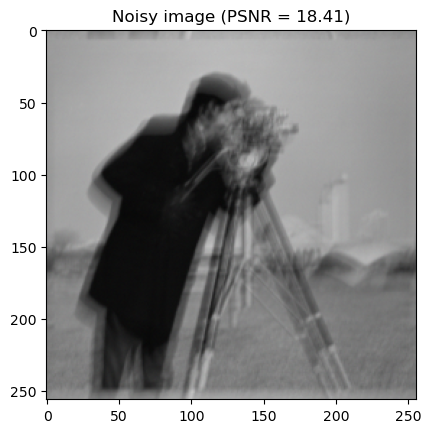

In [15]:
image, _, noisy_image, _ = init_denoising("images/photographer.png")

image = image.squeeze().permute(1, 2, 0)
noisy_image = noisy_image.squeeze().permute(1, 2, 0)

noisy_psnr = psnr(image, noisy_image)

plt.title(f"Noisy image (PSNR = {noisy_psnr:.2f})")
plt.imshow(noisy_image, cmap='gray')

## PNP-PGD

[   0/   2] [0.00000 s] PSNR = 18.41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010300685..0.8805337].


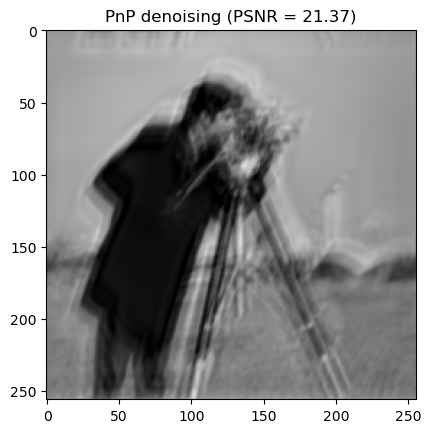

In [18]:
x_pnp, psnr_pnp = pnp_pgd_denoising("images/photographer.png", niter=2)

plt.title(f"PnP denoising (PSNR = {psnr_pnp:.2f})")
plt.imshow(x_pnp, cmap='gray')

## RED-PGD

/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/deepinv/models/GSPnP.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(pretrained, map_lo

[   0/   2] [0.00000 s] PSNR = 18.41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03538412..0.8144052].


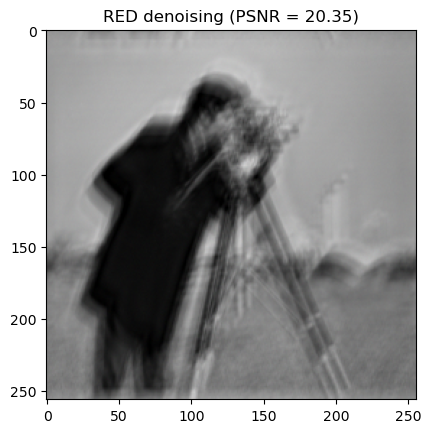

In [20]:
x_red, psnr_red = red_denoising("images/photographer.png", niter=2)

plt.title(f"RED denoising (PSNR = {psnr_red:.2f})")
plt.imshow(x_red)

## CRR-NN

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


  0%|          | 0/3 [00:00<?, ?it/s]/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/Users/sullivancastro/miniforge3/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
psnr: 20.06 | ssim: 0.7309 | res: 1.69e-01: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


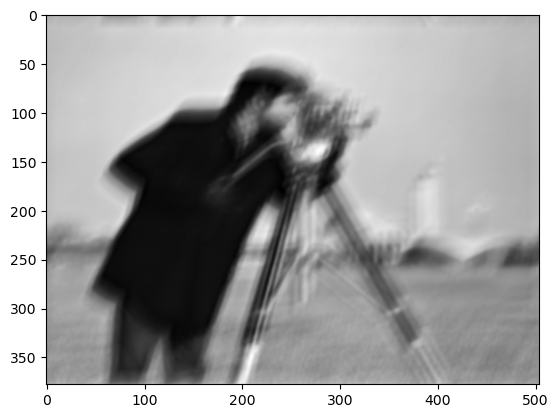

In [22]:
x_crr, psnr_crr = crr_nn_denoising("images/photographer.png", niter=3, lmbd=0.11, mu=10)
plt.imshow(x_crr.numpy(), cmap="gray")

### Fine-tuning

In [ ]:
lmbd_test = np.linspace(0.001, 10, 10)
lmbd_array = np.zeros((10, 10))

for i, lmbd_ in enumerate(lmbd_test):
    for j in range(10):
        x_crr, psnr_crr = crr_nn_denoising("images/photographer.png", niter=3, lmbd=lmbd_, mu=10)
        lmbd_array[i, j] = psnr_crr

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


/Users/sullivancastro/Desktop/MVA/S2/GMI/Project/code/convex_ridge_regularizers/models/utils.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(che

--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.07 | ssim: 0.7316 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.07 | ssim: 0.7315 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.07 | ssim: 0.7315 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.07 | ssim: 0.7315 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.93it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.07 | ssim: 0.7316 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.07 | ssim: 0.7316 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.07 | ssim: 0.7315 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.07 | ssim: 0.7316 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.07 | ssim: 0.7315 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7310 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7309 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7309 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7309 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7309 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7309 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7309 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7309 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7308 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.06 | ssim: 0.7309 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7302 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7302 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7302 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7302 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7302 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7302 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7302 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7302 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.82it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7303 | res: 1.69e-01: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.05 | ssim: 0.7302 | res: 1.69e-01: 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7295 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7295 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7296 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7295 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7296 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7295 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7295 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7296 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7296 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.04 | ssim: 0.7295 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7288 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7289 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7288 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7288 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7288 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7289 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7288 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7288 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7288 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.03 | ssim: 0.7288 | res: 1.70e-01: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7282 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7282 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7282 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7282 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7281 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7282 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7282 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7280 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7282 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.02 | ssim: 0.7282 | res: 1.71e-01: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7274 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7275 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7275 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7275 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7276 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7275 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7275 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7276 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7275 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 20.00 | ssim: 0.7276 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7268 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7269 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7268 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.67it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7270 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7269 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7269 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7268 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7269 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7269 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.99 | ssim: 0.7269 | res: 1.72e-01: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7262 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7261 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.63it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7262 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7262 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7262 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7261 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7261 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7262 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7262 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.97 | ssim: 0.7262 | res: 1.73e-01: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7254 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7254 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7255 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7254 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7253 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.66it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7254 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7254 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7255 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7254 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


--- loading checkpoint from epoch 10 ---
---------------------
Building a CRR-NN model with 
 - [1, 8, 32] channels 
 splines parameters:
  (LinearSpline(mode=conv, num_activations=32, init=zero, size=21, grid=0.010, monotonic_constraint=True.))
---------------------
---------------------
 PRUNNING 
 Found 23 filters with non-vanishing potential functions
---------------------
 Number of parameters after prunning: 4373


psnr: 19.96 | ssim: 0.7254 | res: 1.74e-01: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]


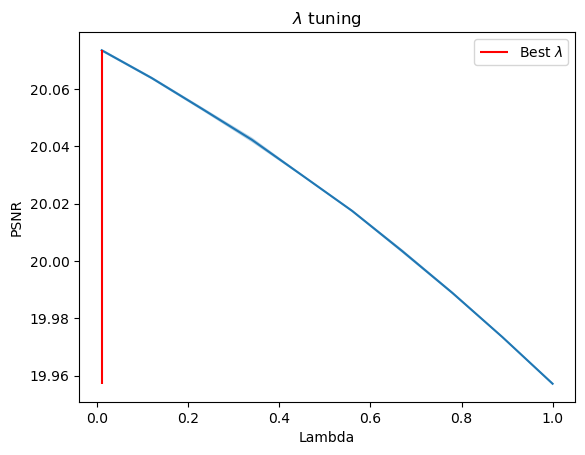

In [36]:
plt.figure()
plt.plot(lmbd_test, lmbd_array.mean(axis=1))
plt.fill_between(lmbd_test, lmbd_array.mean(axis=1) - lmbd_array.std(axis=1), lmbd_array.mean(axis=1) + lmbd_array.std(axis=1), alpha=0.3)
plt.xlabel("Lambda")
plt.ylabel("PSNR")
plt.title(r"$\lambda$ tuning")
plt.vlines(lmbd_test[np.argmax(lmbd_array.mean(axis=1))], lmbd_array.mean(axis=1).min(), lmbd_array.mean(axis=1).max(), color="red", label=r"Best $\lambda$")
plt.legend()
plt.show()

# Global results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010300685..0.8805337].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03538412..0.8144052].


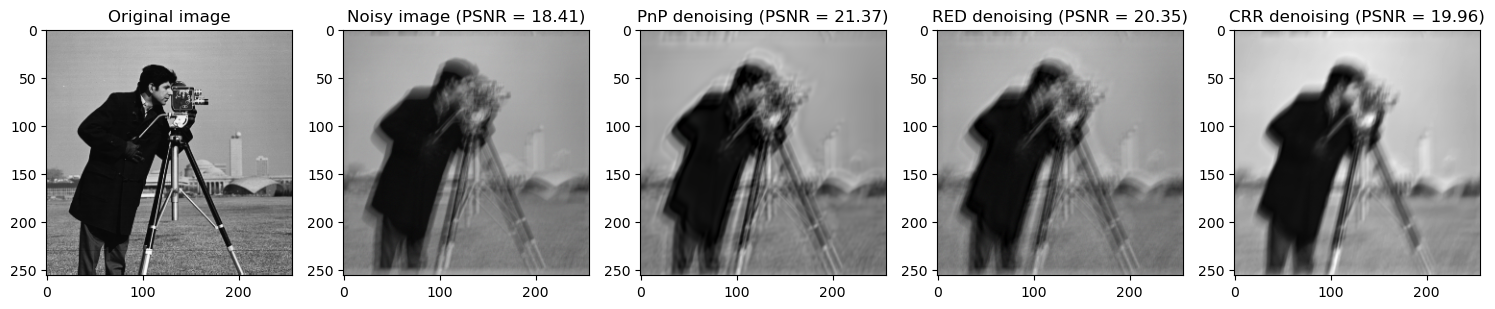

In [49]:
plt.subplots(nrows=1, ncols=5, figsize=(15, 5))

plt.subplot(1, 5, 1)
plt.imshow(image, cmap='gray')
plt.title("Original image")

plt.subplot(1, 5, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f"Noisy image (PSNR = {noisy_psnr:.2f})")

plt.subplot(1, 5, 3)
plt.imshow(x_pnp, cmap='gray')
plt.title(f"PnP denoising (PSNR = {psnr_pnp:.2f})")

plt.subplot(1, 5, 4)
plt.imshow(x_red, cmap='gray')
plt.title(f"RED denoising (PSNR = {psnr_red:.2f})")

plt.subplot(1, 5, 5)
x_crr_resized = cv2.resize(x_crr.numpy(), (256, 256))
plt.imshow(x_crr_resized, cmap='gray')
plt.title(f"CRR denoising (PSNR = {psnr_crr:.2f})")

plt.tight_layout()